In [8]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# MPC import
import numpy as np
from LinearMPC_template.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
from scipy.optimize import least_squares


rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

Subsystem x: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [       inf 0.17453293        inf]
State lower bounds are [       -inf -0.17453293        -inf] 

Subsystem y: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [       inf 0.17453293        inf]
State lower bounds are [       -inf -0.17453293        -inf] 

Subsystem z: 

Input upper bounds are [80.]
Input lower bounds are [40.]
State upper bounds are [inf]
State lower bounds are [-inf] 

Subsystem roll: 

Input upper bounds are [20.]
Input lower bounds are [-20.]
State upper bounds are [inf inf]
State lower bounds are [-inf -inf] 

Simulating time 0.00: Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Maximum

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

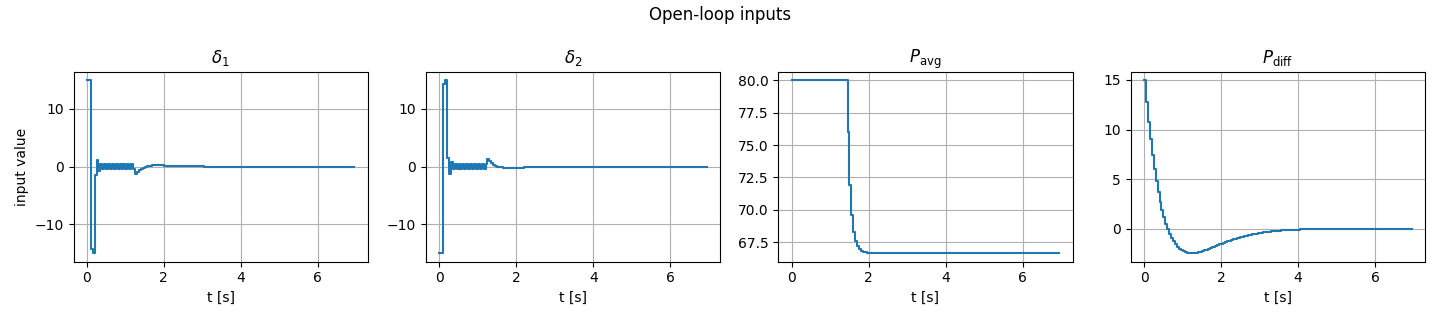

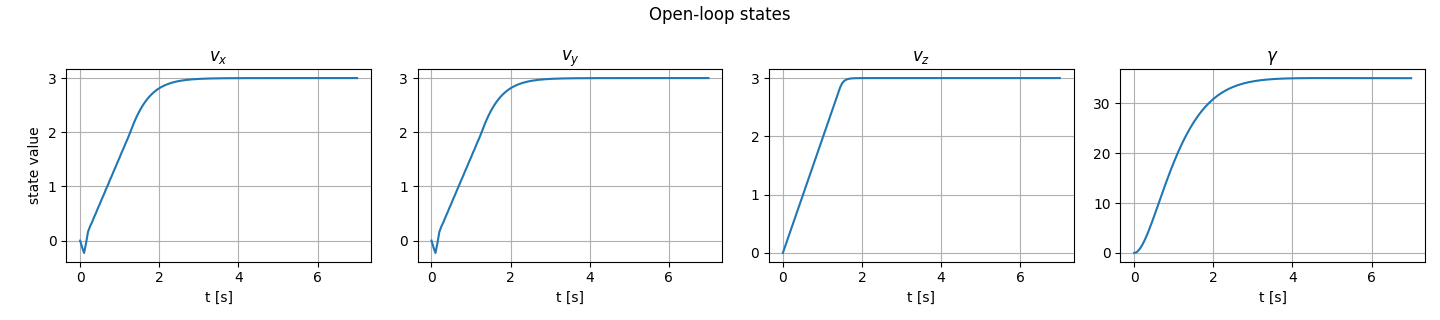

In [10]:
Ts = 0.05
sim_time = 7
H = 5.0

#x0 definition : completely stationnary
omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = 0; v_x0 = 0; v_y0 = 0; v_z0 = 0
x0_full = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0, 0, 0, 0])

#x_target definition : 3 m/s velocities and 35° roll
# Note : 
# 1. x_target already re-shaped from (n,) to (n x N_cl + 1 in simulate_control)
# 2. position targets set at 0. This does NOT lead to any problem at this point because the method mpc.get_u() always keeps position states at 0 and so this target is always fullfilled
#    i.e. it is an equilibrium if states not taken into account.

omega_x_target = 0; omega_y_target = 0; omega_z_target = 0; alpha_target = 0; beta_target = 0; gamma_target = np.deg2rad(35); v_x_target = 3; v_y_target = 3; v_z_target = 3
x_target = np.array([omega_x_target, omega_y_target, omega_z_target, alpha_target, beta_target, gamma_target, v_x_target, v_y_target, v_z_target, 0, 0, 0]) 

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# u_target = u_s, so no need to specify it (see goodnotes)

# simulation
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_full, x_target=x_target, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

# Plotting the closed-loop trajectories
mpc.plot_trajectories(
    t_cl,
    x_cl,
    u_cl,
)